In [1]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from fuzzy_layer import FuzzyLayer

In [2]:
batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
fuzzy_labels = 12 #10 цифр + 2 класса на цифры с кругляшками и без
unknown_classes_ratio = 0.0 # доля неизвестных классов 
is_fuzzy_loss_active = True

prefix = "vae"
if is_fuzzy_loss_active:
    prefix = f"fuzzy_cvae_with_unknown_ratio_{unknown_classes_ratio}"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [4]:
def get_target_and_mask(target_label, unknown_ratio):
    """
    Возвращает вектор целевого значения и маску в виде сдвоенного тензора

    Args:
        target_label (int): Метка класса
        unknown_ratio (float): Доля примеров в датасете, чья разметка будет игнорироваться при обучении
    
    Returns:
        tensor (2, 12)
    """
    t = F.one_hot(torch.LongTensor([target_label]), fuzzy_labels)
    if (target_label == 0) or (target_label == 6) or (target_label == 8) or (target_label == 9):
        t[0][fuzzy_labels - 2] = 1
    else:
        t[0][fuzzy_labels - 1] = 1
    m = torch.ones((1, fuzzy_labels)) if torch.rand(1) > unknown_ratio else torch.zeros((1, fuzzy_labels))
    
    return torch.cat((t, m), 0).to(device) 

In [5]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x,unknown_classes_ratio))
)

In [6]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x, 0))
)
len(test_data)

10000

In [7]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [8]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [9]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [10]:
class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder (C-VAE) 
    
    Args:
        latent_dim (int): Размер латентного вектора.
        labels_count (int): Количество выходов классификатора
    """
    def __init__(self, latent_dim, labels_count):
        super(CVAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)

        self.fuzzy = nn.Sequential(
             FuzzyLayer.fromdimentions(latent_dim, labels_count, trainable=True)

        )
        
    def forward(self, x):
        """
        Возвращает компоненты внутренних слоев CVAE, результаты реконструкции и классификации
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            mu, x_recon, labels
        """

        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        labels = self.fuzzy(mu)

        return mu, x_recon, labels
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z = self.encoder(x)
        labels = self.fuzzy(mu)

        return mu, logvar, z, labels
    
    def decoder_pass(self, x):
        return self.decoder(x)


In [11]:
def compute_loss(x, recon_x, mu, logvar, z, target_labels, predicted_labels):
    
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
            
    target_firings = target_labels[:,0,:]
    mask = target_labels[:,1,:]
    loss_fuzzy = (mask * torch.square(target_firings - predicted_labels)).sum(-1).mean()

    loss = loss_recon + loss_kl

    if is_fuzzy_loss_active:
        loss += loss_fuzzy

    return loss, loss_recon, loss_kl, loss_fuzzy
    

In [12]:
model = CVAE(latent_dim=latent_dim, labels_count=fuzzy_labels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,690,329


CVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=4, bias=True)
    )
    (softplus): Softplus(beta=1, threshold=20)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [14]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logcar, z, labels = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z, target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Fuzzy: {loss_fuzzy.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('Fuzzy/Train/Loss', loss_fuzzy.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [15]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_fuzzy_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            mu, logcar, z, labels = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z,  target, labels)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fuzzy_loss += loss_fuzzy.item()
            pred_target = np.argmax(labels[:,0:(fuzzy_labels-2)].cpu().numpy(), axis=1)
            target_labels =  np.argmax(target[:,0,0:(fuzzy_labels-2)].cpu().numpy(), axis=1)
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fuzzy_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} Fuzzy: {test_fuzzy_loss:.4f} Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', loss_kl.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Loss', loss_fuzzy.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [16]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 19.3946 (Recon: 17.3990, KL: 0.1771 Fuzzy: 1.8186) Grad: 13.3685
Step 100 (N samples: 25,600), Loss: 8.9658 (Recon: 7.5130, KL: 0.4632 Fuzzy: 0.9896) Grad: 30.2885
Step 200 (N samples: 51,200), Loss: 8.2530 (Recon: 6.9645, KL: 0.4412 Fuzzy: 0.8473) Grad: 8.9464


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.1576 (BCE: 6.7823, KLD: 0.5949 Fuzzy: 0.7804 Accuracy 0.4134)
Epoch 2/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 7.7831 (Recon: 6.5260, KL: 0.4971 Fuzzy: 0.7600) Grad: 2.3423
Step 400 (N samples: 102,400), Loss: 7.8624 (Recon: 6.5754, KL: 0.5778 Fuzzy: 0.7093) Grad: 5.4683


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.9028 (BCE: 6.3700, KLD: 0.8585 Fuzzy: 0.6743 Accuracy 0.5010)
Epoch 3/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 7.7477 (Recon: 6.4396, KL: 0.6678 Fuzzy: 0.6403) Grad: 5.7585
Step 600 (N samples: 153,600), Loss: 7.8815 (Recon: 6.5201, KL: 0.7409 Fuzzy: 0.6205) Grad: 5.3917
Step 700 (N samples: 179,200), Loss: 7.7715 (Recon: 6.4069, KL: 0.7979 Fuzzy: 0.5666) Grad: 4.1939


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.6840 (BCE: 6.2873, KLD: 0.8619 Fuzzy: 0.5348 Accuracy 0.6496)
Epoch 4/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 7.7210 (Recon: 6.4054, KL: 0.8010 Fuzzy: 0.5147) Grad: 5.5715
Step 900 (N samples: 230,400), Loss: 7.6300 (Recon: 6.3479, KL: 0.8274 Fuzzy: 0.4548) Grad: 5.1222


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5013 (BCE: 6.1719, KLD: 0.8699 Fuzzy: 0.4595 Accuracy 0.7526)
Epoch 5/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 7.5063 (Recon: 6.1821, KL: 0.8528 Fuzzy: 0.4714) Grad: 1.7459
Step 1,100 (N samples: 281,600), Loss: 7.4843 (Recon: 6.2218, KL: 0.8600 Fuzzy: 0.4025) Grad: 2.8487


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5087 (BCE: 6.1954, KLD: 0.9015 Fuzzy: 0.4118 Accuracy 0.7952)
Epoch 6/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,200 (N samples: 307,200), Loss: 7.4455 (Recon: 6.1903, KL: 0.8817 Fuzzy: 0.3734) Grad: 1.9287
Step 1,300 (N samples: 332,800), Loss: 7.2315 (Recon: 5.9442, KL: 0.9144 Fuzzy: 0.3729) Grad: 2.6957
Step 1,400 (N samples: 358,400), Loss: 7.3464 (Recon: 6.0732, KL: 0.9198 Fuzzy: 0.3533) Grad: 3.0703


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3616 (BCE: 6.0781, KLD: 0.9504 Fuzzy: 0.3330 Accuracy 0.8653)
Epoch 7/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,500 (N samples: 384,000), Loss: 7.2873 (Recon: 6.0260, KL: 0.9421 Fuzzy: 0.3192) Grad: 2.2770
Step 1,600 (N samples: 409,600), Loss: 7.5072 (Recon: 6.3256, KL: 0.8696 Fuzzy: 0.3120) Grad: 2.2005


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3929 (BCE: 6.0838, KLD: 0.9946 Fuzzy: 0.3145 Accuracy 0.8933)
Epoch 8/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,700 (N samples: 435,200), Loss: 7.3162 (Recon: 6.1210, KL: 0.9009 Fuzzy: 0.2943) Grad: 1.5413
Step 1,800 (N samples: 460,800), Loss: 7.3122 (Recon: 6.0891, KL: 0.9304 Fuzzy: 0.2927) Grad: 2.2001


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2910 (BCE: 6.1094, KLD: 0.9300 Fuzzy: 0.2516 Accuracy 0.9192)
Epoch 9/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,900 (N samples: 486,400), Loss: 7.3945 (Recon: 6.1885, KL: 0.9453 Fuzzy: 0.2608) Grad: 2.6736
Step 2,000 (N samples: 512,000), Loss: 7.4036 (Recon: 6.2305, KL: 0.9057 Fuzzy: 0.2674) Grad: 1.5218
Step 2,100 (N samples: 537,600), Loss: 7.3281 (Recon: 6.1865, KL: 0.8976 Fuzzy: 0.2440) Grad: 1.6624


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2931 (BCE: 6.0942, KLD: 0.9558 Fuzzy: 0.2432 Accuracy 0.9289)
Epoch 10/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,200 (N samples: 563,200), Loss: 7.2851 (Recon: 6.1223, KL: 0.9267 Fuzzy: 0.2361) Grad: 1.8711
Step 2,300 (N samples: 588,800), Loss: 7.5047 (Recon: 6.3026, KL: 0.9293 Fuzzy: 0.2728) Grad: 2.1190


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2532 (BCE: 6.1110, KLD: 0.9170 Fuzzy: 0.2252 Accuracy 0.9375)
Epoch 11/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,400 (N samples: 614,400), Loss: 7.4870 (Recon: 6.2997, KL: 0.9102 Fuzzy: 0.2771) Grad: 2.3681
Step 2,500 (N samples: 640,000), Loss: 7.3228 (Recon: 6.1262, KL: 0.9558 Fuzzy: 0.2408) Grad: 2.0606


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2607 (BCE: 6.0506, KLD: 0.9735 Fuzzy: 0.2365 Accuracy 0.9385)
Epoch 12/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,600 (N samples: 665,600), Loss: 7.2911 (Recon: 6.1072, KL: 0.9486 Fuzzy: 0.2353) Grad: 1.3114
Step 2,700 (N samples: 691,200), Loss: 7.6152 (Recon: 6.3935, KL: 0.9348 Fuzzy: 0.2868) Grad: 2.0988
Step 2,800 (N samples: 716,800), Loss: 7.3213 (Recon: 6.1572, KL: 0.9345 Fuzzy: 0.2295) Grad: 2.1706


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2388 (BCE: 6.0663, KLD: 0.9525 Fuzzy: 0.2200 Accuracy 0.9454)
Epoch 13/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,900 (N samples: 742,400), Loss: 7.1456 (Recon: 5.9752, KL: 0.9336 Fuzzy: 0.2368) Grad: 2.1656
Step 3,000 (N samples: 768,000), Loss: 7.3398 (Recon: 6.1721, KL: 0.9276 Fuzzy: 0.2401) Grad: 2.3550


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2166 (BCE: 6.0717, KLD: 0.9339 Fuzzy: 0.2110 Accuracy 0.9437)
Epoch 14/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,100 (N samples: 793,600), Loss: 7.2834 (Recon: 6.1088, KL: 0.9466 Fuzzy: 0.2280) Grad: 2.3530
Step 3,200 (N samples: 819,200), Loss: 7.1773 (Recon: 5.9287, KL: 0.9418 Fuzzy: 0.3067) Grad: 2.6642


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2244 (BCE: 6.0976, KLD: 0.9208 Fuzzy: 0.2060 Accuracy 0.9501)
Epoch 15/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,300 (N samples: 844,800), Loss: 7.1932 (Recon: 6.0545, KL: 0.9409 Fuzzy: 0.1979) Grad: 1.8342
Step 3,400 (N samples: 870,400), Loss: 7.1400 (Recon: 5.9701, KL: 0.9461 Fuzzy: 0.2238) Grad: 1.3854
Step 3,500 (N samples: 896,000), Loss: 7.2521 (Recon: 6.0690, KL: 0.9381 Fuzzy: 0.2451) Grad: 2.2797


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1992 (BCE: 6.0357, KLD: 0.9652 Fuzzy: 0.1984 Accuracy 0.9500)
Epoch 16/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,600 (N samples: 921,600), Loss: 7.3110 (Recon: 6.1059, KL: 0.9856 Fuzzy: 0.2194) Grad: 1.7362
Step 3,700 (N samples: 947,200), Loss: 7.3091 (Recon: 6.1758, KL: 0.9076 Fuzzy: 0.2257) Grad: 1.6642


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2206 (BCE: 6.1142, KLD: 0.9142 Fuzzy: 0.1923 Accuracy 0.9534)
Epoch 17/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,800 (N samples: 972,800), Loss: 7.1501 (Recon: 6.0712, KL: 0.9032 Fuzzy: 0.1757) Grad: 1.6624
Step 3,900 (N samples: 998,400), Loss: 7.3468 (Recon: 6.1645, KL: 0.9632 Fuzzy: 0.2190) Grad: 2.1913


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1982 (BCE: 6.0607, KLD: 0.9459 Fuzzy: 0.1917 Accuracy 0.9527)
Epoch 18/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,000 (N samples: 1,024,000), Loss: 7.2510 (Recon: 6.0993, KL: 0.9502 Fuzzy: 0.2015) Grad: 2.1903
Step 4,100 (N samples: 1,049,600), Loss: 7.3392 (Recon: 6.1657, KL: 0.9753 Fuzzy: 0.1982) Grad: 1.7712
Step 4,200 (N samples: 1,075,200), Loss: 7.3127 (Recon: 6.1607, KL: 0.9441 Fuzzy: 0.2079) Grad: 2.5686


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1776 (BCE: 6.0519, KLD: 0.9379 Fuzzy: 0.1879 Accuracy 0.9534)
Epoch 19/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,300 (N samples: 1,100,800), Loss: 7.2884 (Recon: 6.1600, KL: 0.9328 Fuzzy: 0.1955) Grad: 2.0652
Step 4,400 (N samples: 1,126,400), Loss: 7.1364 (Recon: 6.0404, KL: 0.9275 Fuzzy: 0.1684) Grad: 1.6795


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1758 (BCE: 6.0103, KLD: 0.9797 Fuzzy: 0.1859 Accuracy 0.9513)
Epoch 20/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,500 (N samples: 1,152,000), Loss: 7.3723 (Recon: 6.1851, KL: 1.0036 Fuzzy: 0.1836) Grad: 1.8482
Step 4,600 (N samples: 1,177,600), Loss: 7.1895 (Recon: 6.0563, KL: 0.9392 Fuzzy: 0.1940) Grad: 1.9187


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1923 (BCE: 6.0271, KLD: 0.9780 Fuzzy: 0.1872 Accuracy 0.9563)
Epoch 21/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,700 (N samples: 1,203,200), Loss: 7.4600 (Recon: 6.3230, KL: 0.9371 Fuzzy: 0.1999) Grad: 1.6674
Step 4,800 (N samples: 1,228,800), Loss: 7.3858 (Recon: 6.2260, KL: 0.9650 Fuzzy: 0.1948) Grad: 1.2919
Step 4,900 (N samples: 1,254,400), Loss: 7.0756 (Recon: 5.8952, KL: 1.0030 Fuzzy: 0.1775) Grad: 1.8072


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1593 (BCE: 6.0018, KLD: 0.9791 Fuzzy: 0.1784 Accuracy 0.9574)
Epoch 22/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,000 (N samples: 1,280,000), Loss: 7.0874 (Recon: 5.9245, KL: 0.9732 Fuzzy: 0.1897) Grad: 1.9811
Step 5,100 (N samples: 1,305,600), Loss: 7.2792 (Recon: 6.1468, KL: 0.9504 Fuzzy: 0.1821) Grad: 1.4102


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1590 (BCE: 5.9855, KLD: 0.9997 Fuzzy: 0.1739 Accuracy 0.9587)
Epoch 23/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,200 (N samples: 1,331,200), Loss: 7.3657 (Recon: 6.2174, KL: 0.9420 Fuzzy: 0.2064) Grad: 2.3831
Step 5,300 (N samples: 1,356,800), Loss: 7.5244 (Recon: 6.3272, KL: 0.9600 Fuzzy: 0.2372) Grad: 2.1380
Step 5,400 (N samples: 1,382,400), Loss: 7.5298 (Recon: 6.3196, KL: 0.9712 Fuzzy: 0.2390) Grad: 3.1145


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1751 (BCE: 6.0224, KLD: 0.9756 Fuzzy: 0.1772 Accuracy 0.9594)
Epoch 24/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,500 (N samples: 1,408,000), Loss: 7.3692 (Recon: 6.2321, KL: 0.9417 Fuzzy: 0.1954) Grad: 2.3769
Step 5,600 (N samples: 1,433,600), Loss: 7.1236 (Recon: 5.9318, KL: 0.9902 Fuzzy: 0.2015) Grad: 1.7620


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1774 (BCE: 5.9898, KLD: 1.0103 Fuzzy: 0.1772 Accuracy 0.9608)
Epoch 25/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,700 (N samples: 1,459,200), Loss: 7.1310 (Recon: 5.9287, KL: 1.0278 Fuzzy: 0.1745) Grad: 1.5498
Step 5,800 (N samples: 1,484,800), Loss: 7.2747 (Recon: 6.0950, KL: 0.9718 Fuzzy: 0.2079) Grad: 2.1313


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2073 (BCE: 6.0922, KLD: 0.9328 Fuzzy: 0.1824 Accuracy 0.9585)
Epoch 26/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,900 (N samples: 1,510,400), Loss: 7.1031 (Recon: 5.9365, KL: 0.9816 Fuzzy: 0.1850) Grad: 1.6934
Step 6,000 (N samples: 1,536,000), Loss: 7.1748 (Recon: 6.0199, KL: 0.9642 Fuzzy: 0.1907) Grad: 2.2443
Step 6,100 (N samples: 1,561,600), Loss: 7.2306 (Recon: 6.0890, KL: 0.9640 Fuzzy: 0.1775) Grad: 1.8217


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1480 (BCE: 5.9949, KLD: 0.9718 Fuzzy: 0.1813 Accuracy 0.9595)
Epoch 27/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,200 (N samples: 1,587,200), Loss: 7.1130 (Recon: 5.9050, KL: 1.0233 Fuzzy: 0.1847) Grad: 2.0526
Step 6,300 (N samples: 1,612,800), Loss: 7.1620 (Recon: 5.9857, KL: 1.0203 Fuzzy: 0.1561) Grad: 1.9424


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1705 (BCE: 5.9495, KLD: 1.0439 Fuzzy: 0.1770 Accuracy 0.9609)
Epoch 28/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,400 (N samples: 1,638,400), Loss: 7.0841 (Recon: 5.9178, KL: 0.9787 Fuzzy: 0.1875) Grad: 1.6267
Step 6,500 (N samples: 1,664,000), Loss: 7.0457 (Recon: 5.8570, KL: 1.0099 Fuzzy: 0.1787) Grad: 1.6060


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1711 (BCE: 5.9991, KLD: 0.9940 Fuzzy: 0.1780 Accuracy 0.9609)
Epoch 29/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,600 (N samples: 1,689,600), Loss: 7.2742 (Recon: 6.1117, KL: 0.9693 Fuzzy: 0.1932) Grad: 1.9057
Step 6,700 (N samples: 1,715,200), Loss: 7.0740 (Recon: 5.9103, KL: 0.9960 Fuzzy: 0.1677) Grad: 1.1245
Step 6,800 (N samples: 1,740,800), Loss: 7.1114 (Recon: 5.8800, KL: 1.0210 Fuzzy: 0.2104) Grad: 1.7644


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1604 (BCE: 6.0053, KLD: 0.9881 Fuzzy: 0.1670 Accuracy 0.9627)
Epoch 30/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,900 (N samples: 1,766,400), Loss: 7.2608 (Recon: 6.1160, KL: 0.9842 Fuzzy: 0.1606) Grad: 1.9179
Step 7,000 (N samples: 1,792,000), Loss: 7.4866 (Recon: 6.3288, KL: 0.9947 Fuzzy: 0.1631) Grad: 1.4786


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1471 (BCE: 5.9570, KLD: 1.0234 Fuzzy: 0.1668 Accuracy 0.9593)
Epoch 31/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,100 (N samples: 1,817,600), Loss: 7.1382 (Recon: 5.8701, KL: 0.9987 Fuzzy: 0.2694) Grad: 3.0376
Step 7,200 (N samples: 1,843,200), Loss: 7.1150 (Recon: 5.8917, KL: 1.0477 Fuzzy: 0.1756) Grad: 2.2530


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1276 (BCE: 5.9861, KLD: 0.9864 Fuzzy: 0.1551 Accuracy 0.9638)
Epoch 32/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,300 (N samples: 1,868,800), Loss: 7.3168 (Recon: 6.1124, KL: 1.0101 Fuzzy: 0.1944) Grad: 1.8847
Step 7,400 (N samples: 1,894,400), Loss: 7.0489 (Recon: 5.8569, KL: 1.0199 Fuzzy: 0.1721) Grad: 1.3959
Step 7,500 (N samples: 1,920,000), Loss: 7.1298 (Recon: 5.9828, KL: 0.9996 Fuzzy: 0.1473) Grad: 1.3012


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1229 (BCE: 5.9378, KLD: 1.0291 Fuzzy: 0.1561 Accuracy 0.9646)
Epoch 33/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,600 (N samples: 1,945,600), Loss: 7.2011 (Recon: 6.0448, KL: 1.0023 Fuzzy: 0.1540) Grad: 1.6470
Step 7,700 (N samples: 1,971,200), Loss: 7.1810 (Recon: 5.9281, KL: 1.0626 Fuzzy: 0.1902) Grad: 2.4078


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1112 (BCE: 5.9633, KLD: 0.9892 Fuzzy: 0.1586 Accuracy 0.9625)
Epoch 34/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,800 (N samples: 1,996,800), Loss: 7.0233 (Recon: 5.8859, KL: 1.0122 Fuzzy: 0.1252) Grad: 1.6114
Step 7,900 (N samples: 2,022,400), Loss: 7.1584 (Recon: 5.9738, KL: 1.0096 Fuzzy: 0.1750) Grad: 2.0055


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1169 (BCE: 5.9099, KLD: 1.0449 Fuzzy: 0.1621 Accuracy 0.9633)
Epoch 35/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,000 (N samples: 2,048,000), Loss: 7.1539 (Recon: 6.0213, KL: 0.9997 Fuzzy: 0.1329) Grad: 1.1854
Step 8,100 (N samples: 2,073,600), Loss: 7.1633 (Recon: 5.9818, KL: 1.0358 Fuzzy: 0.1457) Grad: 1.1388
Step 8,200 (N samples: 2,099,200), Loss: 7.1858 (Recon: 6.0197, KL: 1.0004 Fuzzy: 0.1657) Grad: 1.6821


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1463 (BCE: 5.9623, KLD: 1.0285 Fuzzy: 0.1555 Accuracy 0.9613)
Epoch 36/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,300 (N samples: 2,124,800), Loss: 7.1455 (Recon: 5.9633, KL: 1.0214 Fuzzy: 0.1609) Grad: 1.4257
Step 8,400 (N samples: 2,150,400), Loss: 7.2608 (Recon: 6.0795, KL: 0.9928 Fuzzy: 0.1885) Grad: 1.8925


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1250 (BCE: 5.9856, KLD: 0.9866 Fuzzy: 0.1529 Accuracy 0.9633)
Epoch 37/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,500 (N samples: 2,176,000), Loss: 7.1440 (Recon: 5.9275, KL: 1.0602 Fuzzy: 0.1563) Grad: 2.0683
Step 8,600 (N samples: 2,201,600), Loss: 7.2145 (Recon: 5.9854, KL: 1.0688 Fuzzy: 0.1603) Grad: 1.2689


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1155 (BCE: 5.9131, KLD: 1.0507 Fuzzy: 0.1518 Accuracy 0.9646)
Epoch 38/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,700 (N samples: 2,227,200), Loss: 7.3806 (Recon: 6.1754, KL: 1.0041 Fuzzy: 0.2011) Grad: 2.7371
Step 8,800 (N samples: 2,252,800), Loss: 7.0767 (Recon: 5.8893, KL: 1.0287 Fuzzy: 0.1586) Grad: 1.6573
Step 8,900 (N samples: 2,278,400), Loss: 7.0243 (Recon: 5.8237, KL: 1.0523 Fuzzy: 0.1482) Grad: 1.8655


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1295 (BCE: 5.8863, KLD: 1.0849 Fuzzy: 0.1582 Accuracy 0.9629)
Epoch 39/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,000 (N samples: 2,304,000), Loss: 6.9477 (Recon: 5.7641, KL: 1.0648 Fuzzy: 0.1188) Grad: 1.6381
Step 9,100 (N samples: 2,329,600), Loss: 7.0158 (Recon: 5.7884, KL: 1.0498 Fuzzy: 0.1776) Grad: 2.3138


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1023 (BCE: 5.8850, KLD: 1.0606 Fuzzy: 0.1568 Accuracy 0.9646)
Epoch 40/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,200 (N samples: 2,355,200), Loss: 7.1658 (Recon: 5.9563, KL: 1.0441 Fuzzy: 0.1655) Grad: 1.7540
Step 9,300 (N samples: 2,380,800), Loss: 7.1837 (Recon: 5.9626, KL: 1.0187 Fuzzy: 0.2024) Grad: 2.6241


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1106 (BCE: 5.9377, KLD: 1.0208 Fuzzy: 0.1521 Accuracy 0.9641)
Epoch 41/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,400 (N samples: 2,406,400), Loss: 7.2446 (Recon: 6.0335, KL: 1.0426 Fuzzy: 0.1685) Grad: 2.1809
Step 9,500 (N samples: 2,432,000), Loss: 7.0389 (Recon: 5.8257, KL: 1.0510 Fuzzy: 0.1622) Grad: 2.2756
Step 9,600 (N samples: 2,457,600), Loss: 7.0747 (Recon: 5.8657, KL: 1.0630 Fuzzy: 0.1460) Grad: 1.3917


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1161 (BCE: 5.9368, KLD: 1.0329 Fuzzy: 0.1464 Accuracy 0.9646)
Epoch 42/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,700 (N samples: 2,483,200), Loss: 7.2393 (Recon: 6.0469, KL: 1.0377 Fuzzy: 0.1547) Grad: 1.5391
Step 9,800 (N samples: 2,508,800), Loss: 7.1567 (Recon: 5.9204, KL: 1.0293 Fuzzy: 0.2070) Grad: 1.6131


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1160 (BCE: 5.9363, KLD: 1.0377 Fuzzy: 0.1420 Accuracy 0.9646)
Epoch 43/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,900 (N samples: 2,534,400), Loss: 7.0833 (Recon: 5.8894, KL: 1.0425 Fuzzy: 0.1514) Grad: 1.7942
Step 10,000 (N samples: 2,560,000), Loss: 7.1857 (Recon: 6.0033, KL: 1.0205 Fuzzy: 0.1618) Grad: 2.2841
Step 10,100 (N samples: 2,585,600), Loss: 7.1025 (Recon: 5.8566, KL: 1.0685 Fuzzy: 0.1774) Grad: 2.1145


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0847 (BCE: 5.8824, KLD: 1.0615 Fuzzy: 0.1408 Accuracy 0.9657)
Epoch 44/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,200 (N samples: 2,611,200), Loss: 7.1447 (Recon: 5.9893, KL: 1.0033 Fuzzy: 0.1521) Grad: 1.3738
Step 10,300 (N samples: 2,636,800), Loss: 7.3441 (Recon: 6.1525, KL: 1.0427 Fuzzy: 0.1489) Grad: 2.1702


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1073 (BCE: 5.9199, KLD: 1.0458 Fuzzy: 0.1415 Accuracy 0.9653)
Epoch 45/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,400 (N samples: 2,662,400), Loss: 7.2019 (Recon: 5.9850, KL: 1.0763 Fuzzy: 0.1406) Grad: 1.7249
Step 10,500 (N samples: 2,688,000), Loss: 7.2458 (Recon: 6.0371, KL: 1.0572 Fuzzy: 0.1516) Grad: 1.6436


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0916 (BCE: 5.8800, KLD: 1.0703 Fuzzy: 0.1413 Accuracy 0.9649)
Epoch 46/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,600 (N samples: 2,713,600), Loss: 7.3877 (Recon: 6.1121, KL: 1.0713 Fuzzy: 0.2043) Grad: 2.4737
Step 10,700 (N samples: 2,739,200), Loss: 7.2547 (Recon: 5.9517, KL: 1.0839 Fuzzy: 0.2192) Grad: 3.0320
Step 10,800 (N samples: 2,764,800), Loss: 6.9727 (Recon: 5.7553, KL: 1.0771 Fuzzy: 0.1403) Grad: 1.8820


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1072 (BCE: 5.9336, KLD: 1.0325 Fuzzy: 0.1411 Accuracy 0.9658)
Epoch 47/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,900 (N samples: 2,790,400), Loss: 7.1671 (Recon: 5.9738, KL: 1.0451 Fuzzy: 0.1482) Grad: 1.9151
Step 11,000 (N samples: 2,816,000), Loss: 7.2598 (Recon: 6.0705, KL: 1.0239 Fuzzy: 0.1653) Grad: 1.9669


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0894 (BCE: 5.8671, KLD: 1.0752 Fuzzy: 0.1471 Accuracy 0.9653)
Epoch 48/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,100 (N samples: 2,841,600), Loss: 6.9980 (Recon: 5.7877, KL: 1.0485 Fuzzy: 0.1618) Grad: 2.9940
Step 11,200 (N samples: 2,867,200), Loss: 7.2507 (Recon: 6.0228, KL: 1.0658 Fuzzy: 0.1622) Grad: 1.5174


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0680 (BCE: 5.8803, KLD: 1.0437 Fuzzy: 0.1440 Accuracy 0.9660)
Epoch 49/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,300 (N samples: 2,892,800), Loss: 7.2732 (Recon: 6.0097, KL: 1.0865 Fuzzy: 0.1770) Grad: 2.0537
Step 11,400 (N samples: 2,918,400), Loss: 7.1841 (Recon: 5.9622, KL: 1.0710 Fuzzy: 0.1510) Grad: 2.0411
Step 11,500 (N samples: 2,944,000), Loss: 7.1246 (Recon: 5.9360, KL: 1.0328 Fuzzy: 0.1559) Grad: 1.5618


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0941 (BCE: 5.9308, KLD: 1.0241 Fuzzy: 0.1392 Accuracy 0.9652)
Epoch 50/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,600 (N samples: 2,969,600), Loss: 7.2094 (Recon: 5.9649, KL: 1.0890 Fuzzy: 0.1555) Grad: 1.9321
Step 11,700 (N samples: 2,995,200), Loss: 6.9489 (Recon: 5.7567, KL: 1.0601 Fuzzy: 0.1320) Grad: 1.5620


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0883 (BCE: 5.8909, KLD: 1.0546 Fuzzy: 0.1428 Accuracy 0.9652)


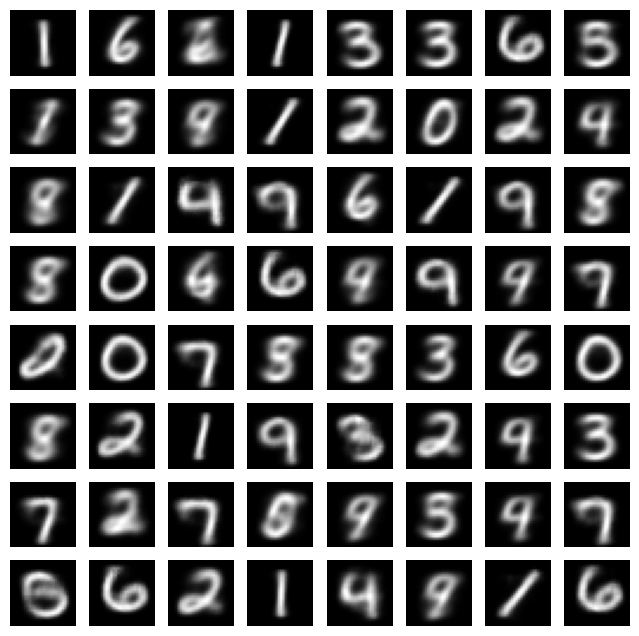

In [17]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

In [18]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
pred_y_all = []
pred_circ_all = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, labels = model.forward(data)
        z_all.append(mu.cpu().numpy())
        y_all.append(np.argmax(target[:,0, 0:(fuzzy_labels-2)].cpu().numpy(), axis=1))
        pred_y_all.append(np.argmax(labels[:, 0:(fuzzy_labels-2)].cpu().numpy(), axis=1))
        pred_circ_all.append(np.argmax(labels[:, (fuzzy_labels-2):].cpu().numpy(), axis=1))

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [19]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
pred_y_all = np.concatenate(pred_y_all, axis=0)
pred_circ_all = np.concatenate(pred_circ_all, axis=0)

In [20]:
np.sum(y_all==pred_y_all)/len(y_all)

0.9644

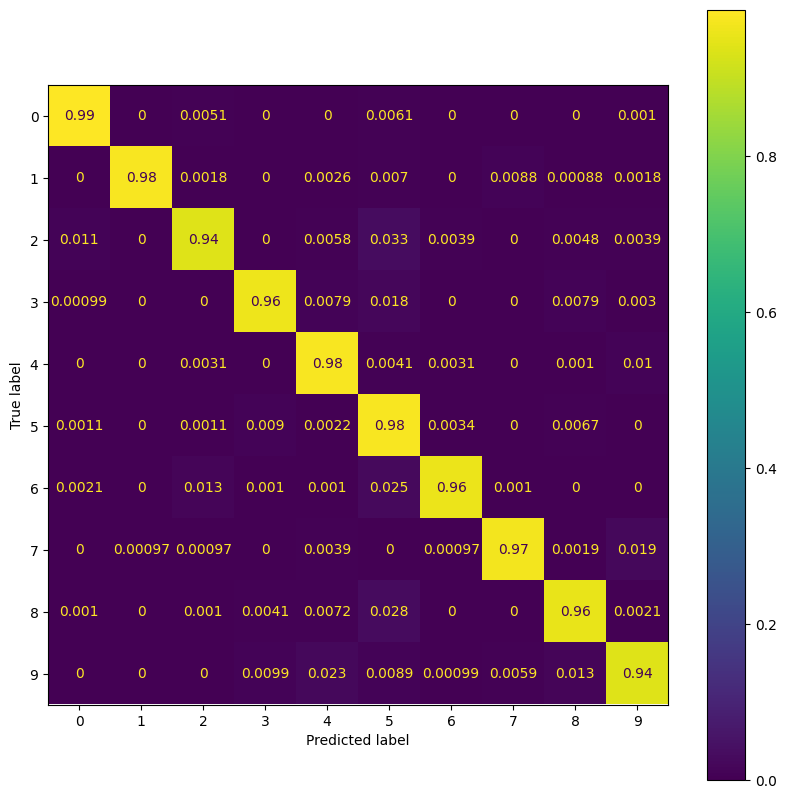

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_all, pred_y_all, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)

Text(0, 0.5, 'cvae 2')

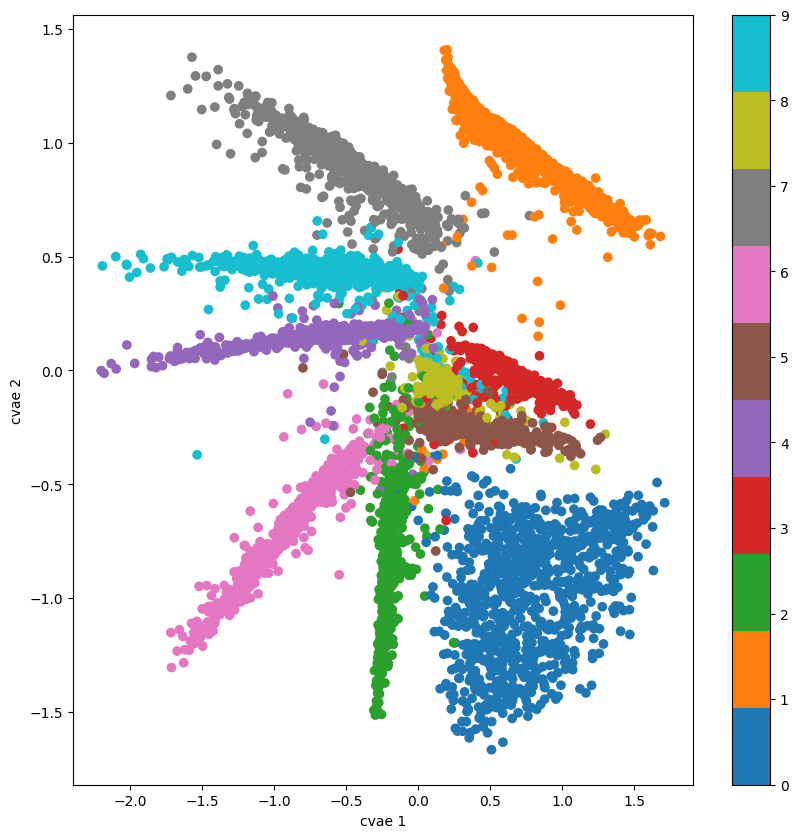

In [22]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
plt.xlabel("cvae 1")
plt.ylabel("cvae 2")
# plt.show()
#plt.savefig('habr/mnist_2d_scatter_origin_labels_cvae.webp')

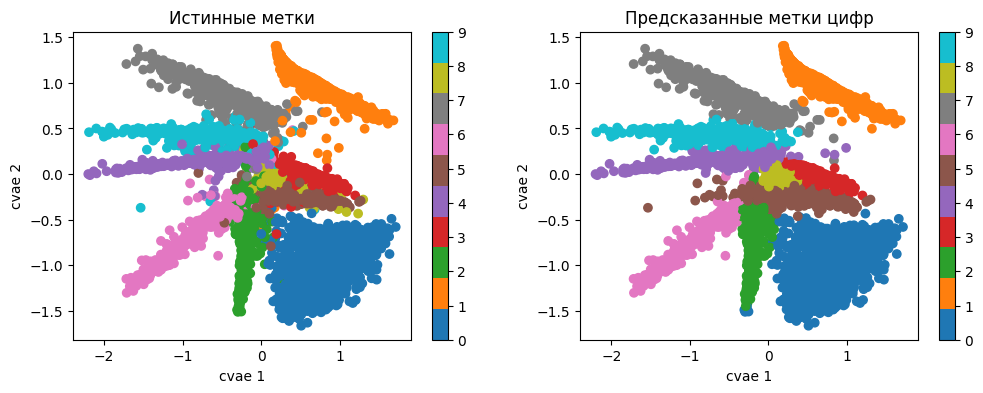

In [32]:
figure, axis = plt.subplots(1, 2, figsize=(12, 4)) 
sc1 =axis[0].scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
axis[0].set_title("Истинные метки")
axis[0].set_xlabel("cvae 1")
axis[0].set_ylabel("cvae 2")

sc2 = axis[1].scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10')
axis[1].set_title("Предсказанные метки цифр") 
axis[1].set_xlabel("cvae 1")
axis[1].set_ylabel("cvae 2")
sc3 = axis[2].scatter(z_all[:, 0], z_all[:, 1], c=pred_circ_all, cmap='spring')
axis[2].set_title("Предсказанные метки очертаний") 
axis[2].set_xlabel("cvae 1")
axis[2].set_ylabel("cvae 2")
figure.colorbar(sc1)
figure.colorbar(sc2)
figure.colorbar(sc3)
plt.show()

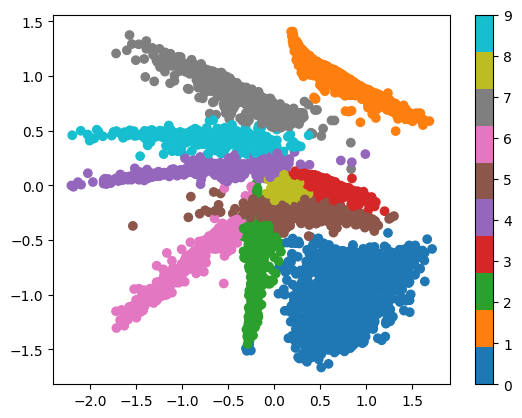

In [24]:

plt.scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('mnist_2d_scatter_fuzzy_pred_labels.webp')

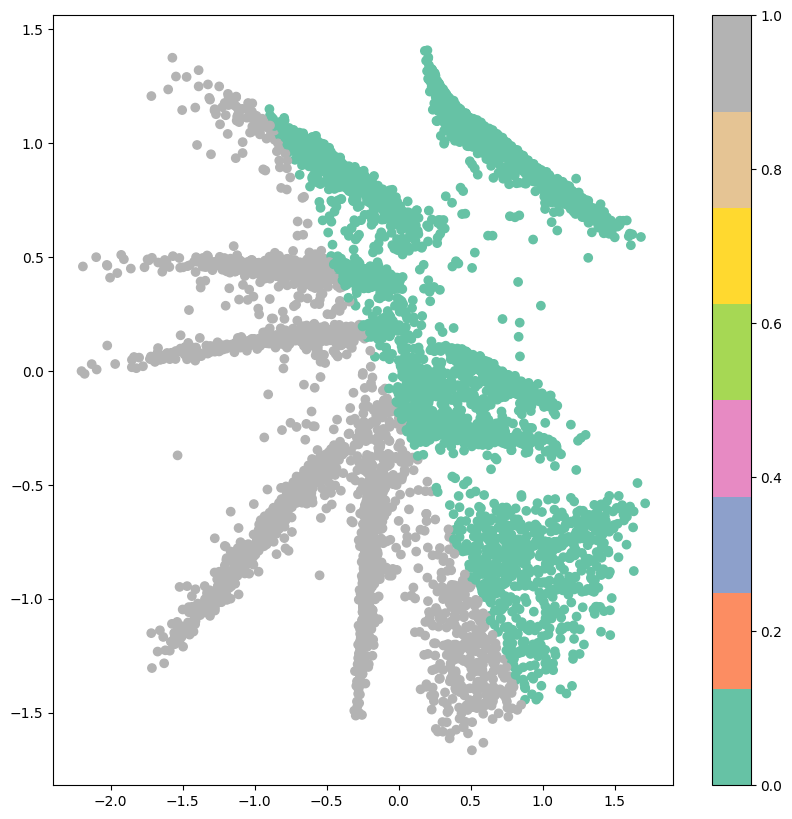

In [25]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=pred_circ_all, cmap='Set2')
plt.colorbar()
# plt.show()
plt.savefig('mnist_2d_scatter_fuzzy_pred_circles.webp')

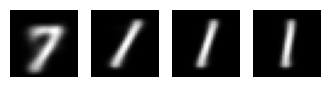

In [26]:
n = 4
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 1.2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('cvae_mnist_interp.webp')